In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision 
from torchvision import transforms

from torch.utils.data import Dataset, DataLoader

from tqdm.autonotebook import tqdm

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

import pandas as pd

from sklearn.metrics import accuracy_score

import time

from idlmam import train_network, Flatten, View, weight_reset,  set_seed

In [3]:
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

from IPython.display import display_pdf
from IPython.display import Latex

<ipython-input-3-024163930d81>:3: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('png', 'pdf')


In [4]:
torch.backends.cudnn.deterministic=True
set_seed(42)

In [5]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [6]:
#How many values are in the input? We use this to help determine the size of subsequent layers
D = 28*28 #28 * 28 images 
#Hidden layer size
n = 2 
#How many channels are in the input?
C = 1
#How many classes are there?
classes = 10

In [7]:
class TransposeLinear(nn.Module): #Our class extends nn.Module, all PyTorch layers must extend this. 
    def __init__(self, linearLayer, bias=True):
        """
        linearLayer: is the layer that we want to use the transpose of to produce the output of this layer. So the Linear layer represents W, and this layer represents W^T. This is accomplished via weight sharing by re-using the weights of linearLayer
        bias: if True, we will crease a new bias term b that is learned separately from what is in linearLayer. If false, we will not use any bias vector. 
        """
        super().__init__()
        
        #We create a new variable weight to store a _reference_ to the original weight term. 
        self.weight = linearLayer.weight
        if bias:
            #We need to create a new bias vector. By default, PyTorch knows how to update Modules and Parameters. Since tensors are not either, the Parameter class wraps the Tensor class, so that PyTorch knows that the values in this tensor need to be updated by gradient descent
            self.bias = nn.Parameter(torch.Tensor(linearLayer.weight.shape[1]))
        else:
            #The Parameter class can not take None as an input. So if we want the bias term to exist, but be  potentially unused, we can use the register_parameter function to create it. The important thing  here is that PyTorch always sees the same parameters regardless of what we set the arguments for the  Module are. 
            self.register_parameter('bias', None)
    
    #The forward function is the code that takes an input and produce an output. 
    def forward(self, x):
        #The F directory of PyTorch contains many _functions_ that are used by Modules. For example, the linear function  performs a linear transform when given an input (we use the transpose of our weights) and a bias (if `None`, it knows to not do anything ).
        return F.linear(x, self.weight.t(), self.bias)
#Caption: This class implements the Transpose operation $W^\top$. The matrix to transpose $W$ must be passed in as the `linearLayer` in the constructor. This way we can share weights between an original `nn.Linear` layer and this transposed version of that layer. 


❶ Our class extends nn.Module. All PyTorch layers must extend this.

❷ Creates a new variable weight to store a reference to the original weight term

❸ Creates a new bias vector. By default, PyTorch knows how to update Modules and Parameters. Since tensors are neither, the Parameter class wraps the Tensor class so PyTorch knows that the values in this tensor need to be updated by gradient descent.

❹ The Parameter class can’t take None as an input. So if we want the bias term to exist but be potentially unused, we can use the register_parameter function to create it. The important thing here is that PyTorch always sees the same parameters regardless of the arguments for the Module.

❺ The forward function is the code that takes an input and produces an output.

❻ The F directory of PyTorch contains many functions used by Modules. For example, the linear function performs a linear transform when given an input (we use the transpose of our weights) and a bias (if None, it knows to not do anything).

In [8]:
#Since we will share the weights of the linear layer, lets define it separately
linearLayer = nn.Linear(D,  n, bias=False)
#The encoder just falltens and then uses the linear layer
pca_encoder = nn.Sequential(
    nn.Flatten(),
    linearLayer,
)
#The decoder uses our TransposeLinear layer + the now shared linearLayer object 
pca_decoder = nn.Sequential(
    TransposeLinear(linearLayer, bias=False),
    View(-1, 1, 28, 28)#Shape the data back to it's original form
)
#Define a final PCA model that is the sequence of an encoder, followed by a decoder
pca_model = nn.Sequential(
    pca_encoder,
    pca_decoder
)

We have everything we need to train up this autoencoder. But to make it truly PCA, we need to add the WW⊤ = I constraint. This constraint has a name: orthogonality. We won’t go into the derivation of why PCA has this, but we will include it as a good exercise. We start our model in the right place by giving it an initial random set of orthogonal weights using the nn.init.orthogonal_ function. That just takes one line of code:

In [10]:
nn.init.orthogonal_(linearLayer.weight)

Parameter containing:
tensor([[-0.0063, -0.0112, -0.0474,  ...,  0.0428,  0.0234, -0.0159],
        [-0.0503,  0.0659, -0.0364,  ...,  0.0330,  0.0096,  0.0341]],
       requires_grad=True)

In [11]:
mse_loss = nn.MSELoss() #Original loss function

def mseWithOrthoLoss(x, y):#our PCA loss function
    #Grabing W from the linearLayer object we saved earlier. 
    W = linearLayer.weight
    #The identity matrix that is the target for the regularized
    I = torch.eye(W.shape[0]).to(device)
    #compute the original loss $\ell_{\mathit{MSE}}(f(\boldsymbol{x}), \boldsymbol{x})$
    normal_loss =  mse_loss(x, y) 
    #compute the regularizer penalty $\ell_{\mathit{MSE}}(W^\top W, \boldsymbol{I})$
    regularization_loss = 0.1*mse_loss(torch.mm(W, W.t()), I)
    #return the sum of the two losses
    return normal_loss + regularization_loss

❶ Original loss function

❷ Our PCA loss function

❸ Grabs W from the linearLayer object we saved earlier

❹ The identity matrix that is the target for regularization

❺ Computes the original loss ℓMSE(f(x),x)

❻ Computes the regularizer penalty ℓMSE(W⊤W,I)

❼ Returns the sum of the two losses

# Implementing PCA with PyTorch

In [12]:
class AutoEncodeDataset(Dataset):
    """Takes a dataset with (x, y) label pairs and converts it to (x, x) pairs. 
    This makes it easy to re-use other code"""

    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        x, y = self.dataset.__getitem__(idx)
        return x, x#just throw away the original label. 

In [13]:
train_data = AutoEncodeDataset(torchvision.datasets.MNIST("./", train=True, transform=transforms.ToTensor(), download=True))
test_data_xy = torchvision.datasets.MNIST("./", train=False, transform=transforms.ToTensor(), download=True)
test_data_xx = AutoEncodeDataset(test_data_xy)

train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
test_loader = DataLoader(test_data_xx, batch_size=128)

100%|██████████| 9912422/9912422 [00:00<00:00, 321139717.48it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 61772408.89it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 167755576.50it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw




100%|██████████| 4542/4542 [00:00<00:00, 10750862.74it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [14]:
train_network(pca_model, mseWithOrthoLoss, train_loader, test_loader=test_loader, epochs=10, device=device)

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

epoch  total time  train loss  test loss
0      0   11.542428    0.064485   0.058074
1      1   20.786629    0.058053   0.057870
2      2   29.793460    0.057895   0.057795
3      3   38.846844    0.057886   0.057814
4      4   49.513685    0.057886   0.057857
5      5   63.921293    0.057889   0.057818
6      6   80.881000    0.057888   0.057843
7      7   90.444890    0.057887   0.057811
8      8   98.968746    0.057886   0.057792
9      9  107.791096    0.057889   0.057857

In [15]:
def encode_batch(encoder, dataset_to_encode):
    """
    encoder: the PyTorch network that takes in a dataset and convers it to a new dimension
    dataset_to_encode: a PyTorch `Dataset` object that we want to convert. 

    Returns a tuple (projected, labels) where `projected` is the encoded version of the dataset, and `labels` are the original labels provided by the `dataset_to_encode`
    """
    #Create space to store the results
    projected = []
    labels = []
    #Switch to eval mode
    encoder = encoder.eval()
    #Switching to CPU mode for simplicty, but you don't have to. 
    encoder = encoder.cpu()
    with torch.no_grad():#We don't want to train, so torch.no_grad! 
        for x, y in  DataLoader(dataset_to_encode, batch_size=128):
            z = encoder(x.cpu()) #encode the original data
            projected.append( z.numpy() ) #store the encoded version & label
            labels.append( y.cpu().numpy().ravel() )
    #Turn the results into single large numpy arrays
    projected = np.vstack(projected)
    labels = np.hstack(labels)
    #return the results
    return projected, labels
#Now lets project our data
projected, labels = encode_batch(pca_encoder, test_data_xy)

<Axes: >

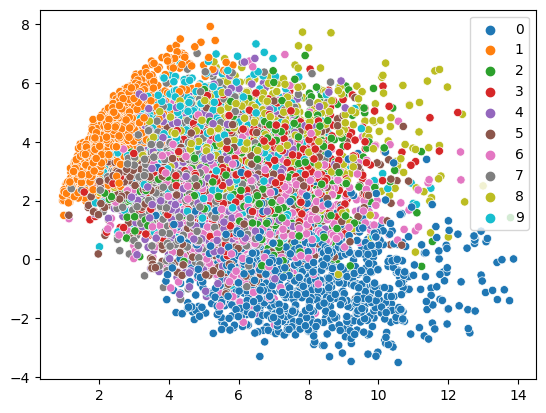

In [16]:
sns.scatterplot(x=projected[:,0], y=projected[:,1], hue=[str(l) for l in labels], hue_order=[str(i) for i in range(10)], legend="full")

Another thing we can use to help judge this is the encode/decode process. If we did a good job, the output should be the same as the input. First, we define a simple helper function to plot the original input x on the left and the encoded-decoded version on the right:

In [17]:
def showEncodeDecode(encode_decode, x):
    """
    encode_decode: the PyTorch Module that does the encoding and decoding steps at once
    x: the input to plot as is, and after encoding & decoding it
    """
    #Switch to eval mode
    encode_decode = encode_decode.eval()
    #We will move things to the CPU so that we don't have to think about what device anything was on
    #and because this functino is not performance sensative
    encode_decode = encode_decode.cpu()
    with torch.no_grad():#Always no_grad if you are not training
        x_recon = encode_decode(x.cpu())
    #Use matplotlib to create a size-by-side plot with the original on the left
    f, axarr = plt.subplots(1,2)
    axarr[0].imshow(x.numpy()[0,:])
    axarr[1].imshow(x_recon.numpy()[0,0,:])

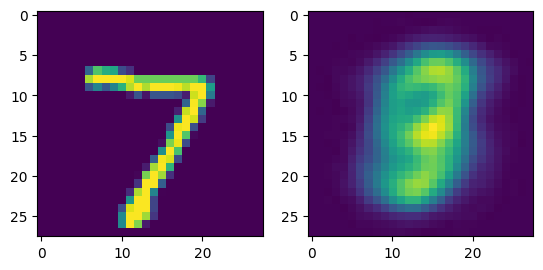

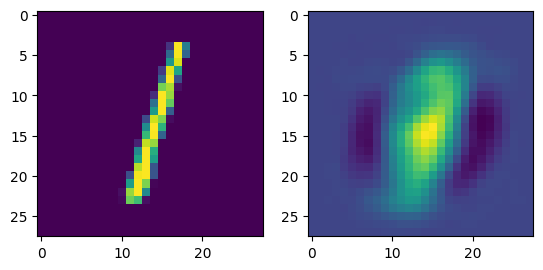

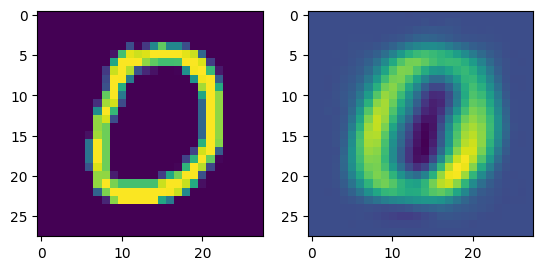

In [18]:
#Showing the input (left) and output (right) for three data points
showEncodeDecode(pca_model, test_data_xy[0][0])
showEncodeDecode(pca_model, test_data_xy[2][0])
showEncodeDecode(pca_model, test_data_xy[10][0])

In [19]:
#First the encoder is augmented by a Tanh non-linearity
pca_nonlinear_encode = nn.Sequential(
    nn.Flatten(),
    nn.Linear(D,  n),
    nn.Tanh(), #The only real change, ading a non-linear operation at the end
)
#The decoder gets its own Linear layer now, making it look more like a normal network
pca_nonlinear_decode = nn.Sequential(
    nn.Linear(n, D),#We are no longer tying the weights for simplicity 
    View(-1, 1, 28, 28)
)
#Combine then together into the encoder-decoder function $f(\cdot)$
pca_nonlinear = nn.Sequential(
    pca_nonlinear_encode,
    pca_nonlinear_decode
)

In [20]:
train_network(pca_nonlinear, mse_loss, train_loader, test_loader=test_loader, epochs=10, device=device)

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

epoch  total time  train loss  test loss
0      0    9.755436    0.132321   0.069795
1      1   18.187624    0.066759   0.066217
2      2   27.013307    0.065827   0.065688
3      3   36.776559    0.065187   0.064853
4      4   45.743990    0.064133   0.063480
5      5   54.904503    0.062394   0.061380
6      6   64.025079    0.060291   0.059420
7      7   73.225855    0.058735   0.058223
8      8   82.282873    0.057855   0.057579
9      9   90.781780    0.057368   0.057194

<Axes: >

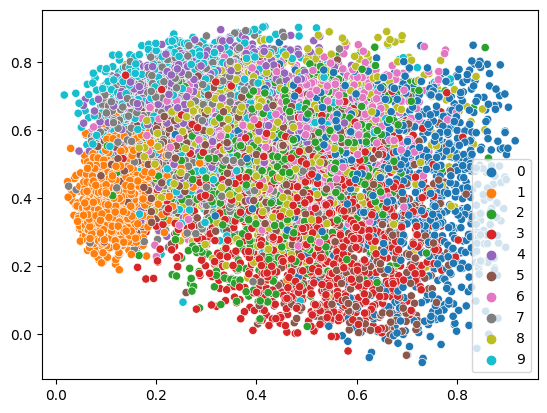

In [21]:
projected, labels = encode_batch(pca_nonlinear_encode, test_data_xy)
sns.scatterplot(x=projected[:,0], y=projected[:,1], hue=[str(l) for l in labels], hue_order=[str(i) for i in range(10)], legend="full" )

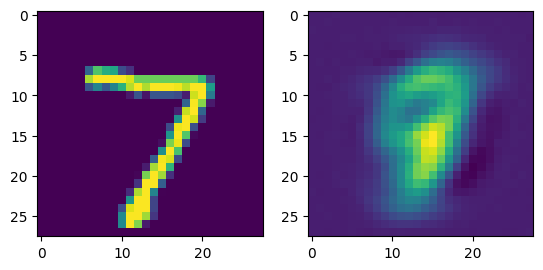

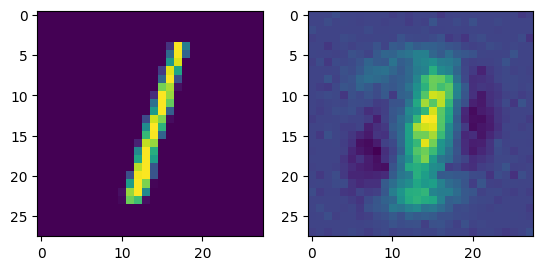

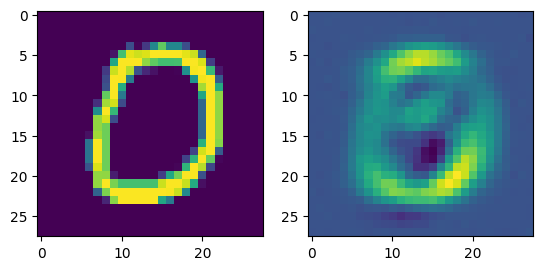

In [22]:
showEncodeDecode(pca_nonlinear, test_data_xy[0][0])
showEncodeDecode(pca_nonlinear, test_data_xy[2][0])
showEncodeDecode(pca_nonlinear, test_data_xy[10][0])

In [23]:
def getLayer(in_size, out_size):
    """
    in_size: how many neurons/features are coming into this layer
    out_size: how many neurons/outputs this hidden layer should produce
    """
    return nn.Sequential( #Organize the conceptual "block" of a hidden layer into a Sequential object
        nn.Linear(in_size,  out_size),
        nn.BatchNorm1d(out_size),
        nn.ReLU())

In [24]:
#Dividing by 2, 3, 4, is one of many patterns that could have been used
auto_encoder = nn.Sequential(
    nn.Flatten(),
    getLayer(D, D//2), #Each of these layers has a smaller output size than the previous
    getLayer(D//2, D//3),
    getLayer(D//3, D//4),
    nn.Linear(D//4,  n), #Jump down to the target dimension
)

#Decoder will do the same layers/sizes in reverse now to be symmetric 
auto_decoder = nn.Sequential(
    getLayer(n, D//4), #Each layer now increases in size because we are in the decoder. 
    getLayer(D//4, D//3),
    getLayer(D//3, D//2),
    nn.Linear(D//2,  D),
    View(-1, 1, 28, 28) #Reshape to match the original shape
)
#Combine into a deep auto encoder
auto_encode_decode = nn.Sequential(
    auto_encoder,
    auto_decoder
)

In [25]:
train_network(auto_encode_decode, mse_loss, train_loader, test_loader=test_loader, epochs=10, device=device)

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

epoch  total time  train loss  test loss
0      0   10.774032    0.050265   0.044376
1      1   21.039901    0.043930   0.041629
2      2   31.372942    0.042521   0.040818
3      3   44.720109    0.041659   0.039826
4      4   55.282059    0.040984   0.039618
5      5   65.675534    0.040436   0.038889
6      6   76.168804    0.040091   0.039228
7      7   86.479188    0.039639   0.038332
8      8   98.787418    0.039247   0.037885
9      9  111.234557    0.038846   0.037812

In [26]:
train_network(auto_encode_decode, mse_loss, train_loader, test_loader=test_loader, epochs=10, device=device)

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

epoch  total time  train loss  test loss
0      0   10.216139    0.038872   0.037524
1      1   23.441828    0.038519   0.037516
2      2   33.722333    0.038272   0.036866
3      3   43.960276    0.038025   0.036864
4      4   54.300280    0.037875   0.036556
5      5   64.510871    0.037676   0.036327
6      6   75.880460    0.037469   0.036398
7      7   86.081190    0.037361   0.036597
8      8   97.699755    0.037197   0.036389
9      9  108.589021    0.037035   0.036013

<Axes: >

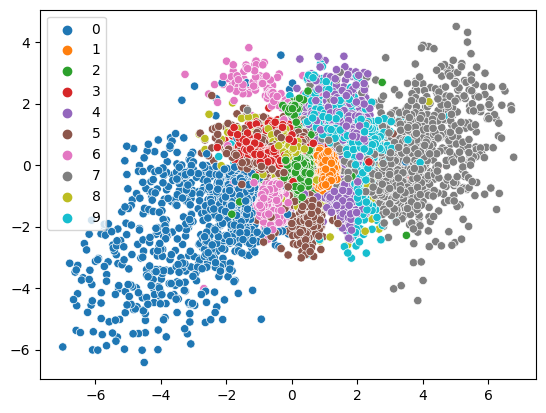

In [27]:
projected, labels = encode_batch(auto_encoder, test_data_xy) 
sns.scatterplot(x=projected[:,0], y=projected[:,1], hue=[str(l) for l in labels], hue_order=[str(i) for i in range(10)], legend="full")

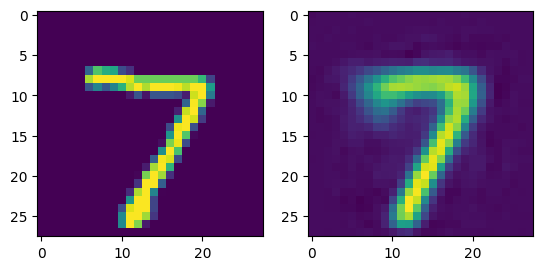

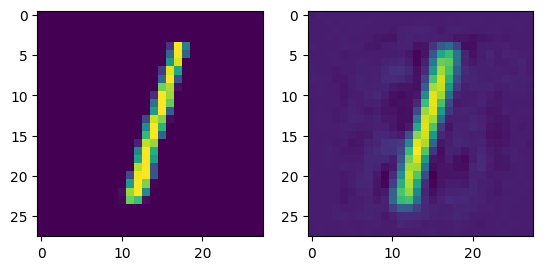

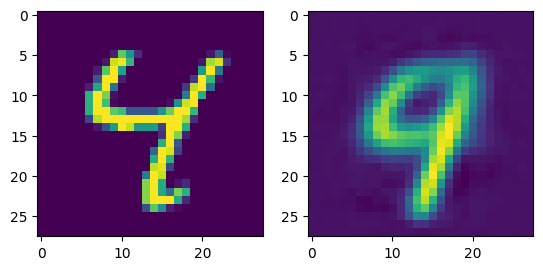

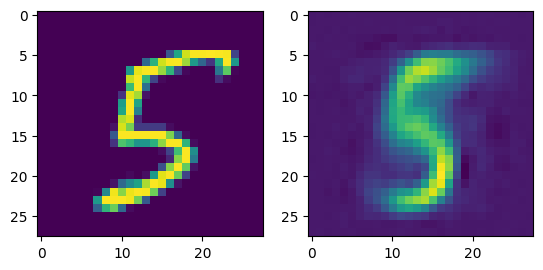

In [28]:
showEncodeDecode(auto_encode_decode, test_data_xy[0][0])
showEncodeDecode(auto_encode_decode, test_data_xy[2][0])
showEncodeDecode(auto_encode_decode, test_data_xy[6][0])
showEncodeDecode(auto_encode_decode, test_data_xy[23][0])

In [29]:
normal = torch.distributions.Normal(0, 0.5)#firs

In [30]:
auto_encoder_big = nn.Sequential(
    nn.Flatten(),
    getLayer(D, D*2),
    getLayer(D*2, D*2),
    getLayer(D*2, D*2),
    nn.Linear(D*2,  D*2),
)

auto_decoder_big = nn.Sequential(
    getLayer(D*2, D*2),
    getLayer(D*2, D*2),
    getLayer(D*2, D*2),
    nn.Linear(D*2,  D),
    View(-1, 1, 28, 28)
)

auto_encode_decode_big = nn.Sequential(
    auto_encoder_big,
    auto_decoder_big
)

In [31]:
train_network(auto_encode_decode_big, mse_loss, train_loader, test_loader=test_loader, epochs=10, device=device)

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

epoch  total time  train loss  test loss
0      0   14.397453    0.024115   0.013268
1      1   31.805746    0.012824   0.010602
2      2   46.196298    0.010487   0.009878
3      3   60.754522    0.009168   0.007771
4      4   75.559025    0.009016   0.008196
5      5   89.730648    0.008089   0.007012
6      6  104.019665    0.007851   0.006793
7      7  118.286818    0.006953   0.006188
8      8  133.910913    0.006972   0.006665
9      9  149.073886    0.006848   0.005850

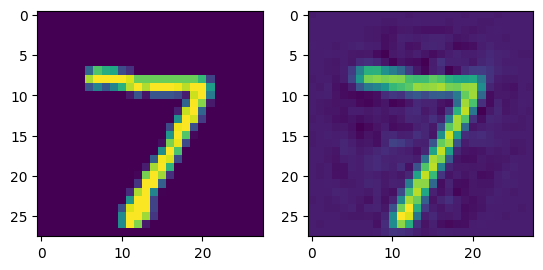

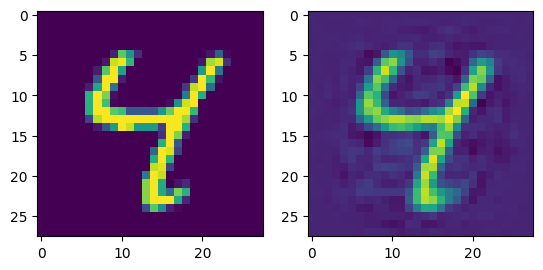

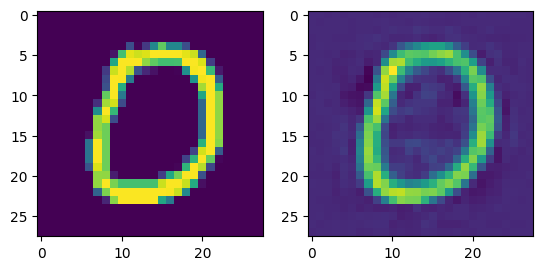

In [32]:
showEncodeDecode(auto_encode_decode_big, test_data_xy[0][0])
showEncodeDecode(auto_encode_decode_big, test_data_xy[6][0])
showEncodeDecode(auto_encode_decode_big, test_data_xy[10][0])

In [33]:
def addNoise(x, device='cpu'): 
    """
    We will use this helper function to add noise to some data. 
    x: the data we want to add noise to
    device: the CPU or GPU that the input is located on. 
    """
    return x + normal.sample(sample_shape=torch.Size(x.shape)).to(device) #$\boldsymbol{x} + s$

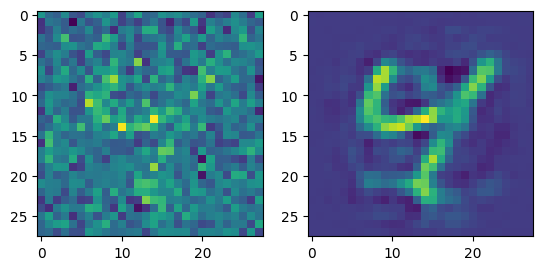

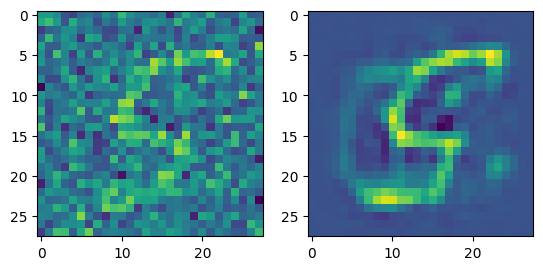

In [34]:
showEncodeDecode(auto_encode_decode_big, addNoise(test_data_xy[6][0]))
showEncodeDecode(auto_encode_decode_big, addNoise(test_data_xy[23][0]))

# Autoregressive models for time series and sequences

The autoencoding approach has been very successful for images, signals, and even fully connected models with tabular data. But what if our data is a sequence problem? Especially if our data is in a language represented by discrete tokens, it’s hard to add meaningful noise to things like a letter or word. Instead, we can use an autoregressive model, which is an approach specifically designed for time-series problems.



In [35]:
from io import BytesIO
from zipfile import ZipFile
from urllib.request import urlopen
import re

all_data = []
resp = urlopen("https://cs.stanford.edu/people/karpathy/char-rnn/shakespear.txt")
shakespear_100k = resp.read()
shakespear_100k = shakespear_100k.decode('utf-8').lower()

Now we will build a vocabulary Σ of all the characters in this dataset. One change you could make is to not use the lower() function to convert everything to lowercase. As we are exploring deep learning, these early decisions are important for how our model will eventually be used and how useful it will be. So, you should learn to recognize choices like this as choices. I’ve chosen to use all lowercase data, and as a result, our vocabulary is smaller. This reduces the difficulty of the task but means our model can’t learn about capitalization.

In [36]:
vocab2indx = {} #the vocab $\Sigma$
for char in shakespear_100k: 
    if char not in vocab2indx: #add every new character to the vocab
        vocab2indx[char] = len(vocab2indx) #set the index based on the current vocab size

#Some useful code to goe from index back to original characters. 
indx2vocab = {}
#Well simply iterate over all key,value pairs and create a dicionary with the inverse mapping. 
for k, v in vocab2indx.items():
    indx2vocab[v] = k
print("Vocab Size: ", len(vocab2indx))
print("Total Characters:", len(shakespear_100k))

Vocab Size:  36
Total Characters: 99993


In [37]:
class AutoRegressiveDataset(Dataset):
    """
    Creates an autoregressive dataset from one single, long, source sequence by breaking it up into "chunks". 
    """

    def __init__(self, large_string, MAX_CHUNK=500):
        """
        large_string: the original long source sequence that chunks will be extracted from
        MAX_CHUNK: the maximum allowed size of any chunk. 
        """
        self.doc = large_string
        self.MAX_CHUNK = MAX_CHUNK

    def __len__(self):
        #The number of items is the number of characters divided by chunk size
        return (len(self.doc)-1) // self.MAX_CHUNK

    def __getitem__(self, idx):
        #Compute the starting position for the idx'th chunk
        start = idx*self.MAX_CHUNK
        #Grab the input sub-string
        sub_string = self.doc[start:start+self.MAX_CHUNK]
        #convert the sub-string into integers based on our vocab
        x = [vocab2indx[c] for c in sub_string]
        
        #grab the label sub-string by shifting over by 1
        sub_string = self.doc[start+1:start+self.MAX_CHUNK+1]
        #convert the label sub-string into integers based on our vocab
        y = [vocab2indx[c] for c in sub_string]
        #convert the 
        return torch.tensor(x, dtype=torch.int64), torch.tensor(y, dtype=torch.int64)
#Caption: Creating a dataset for autoregressive problems from a large text corpus. We assume the corpus exists as one long string, and it is OK to concatenate multiple files together into one long string since our chunks are smaller than most documents are anyway. 

❶ The number of items is the number of characters divided by chunk size.

❷ Computes the starting position for the idx’th chunk

❸ Grabs the input substring

❹ Converts the substring into integers based on our vocab

❺ Grabs the label substring by shifting over by 1

❻ Converts the label substring into integers based on our vocab

In [38]:
class AutoRegressive(nn.Module):

    def __init__(self, num_embeddings, embd_size, hidden_size, layers=1):
        super(AutoRegressive, self).__init__()
        self.hidden_size = hidden_size
        self.embd = nn.Embedding(num_embeddings, embd_size)
        self.layers = nn.ModuleList([nn.GRUCell(embd_size, hidden_size)] + 
                                     [nn.GRUCell(hidden_size, hidden_size) for i in range(layers-1)])
        self.norms = nn.ModuleList([nn.LayerNorm(hidden_size) for i in range(layers)])
        
        self.pred_class = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),# (B, *, D)
            nn.LeakyReLU(),
            nn.LayerNorm(hidden_size), # (B, *, D)
            nn.Linear(hidden_size, num_embeddings) #(B, *. D) -> B(B, *, VocabSize)
        )
        
    def initHiddenStates(self, B):
        """
        Creates an initial hidden state list for the RNN layers. 
        
        B: the batch size for the hidden states. 
        """
        return [torch.zeros(B, self.hidden_size, device=device) for _ in range(len(self.layers))]
        
    def step(self, x_in, h_prevs=None):
        """
        x_in: the input for this current time step and has shape (B) if the values need 
            to be embedded, and (B, D) if they have alreayd been embedded. 

        h_prevs: a list of hidden state tensors each with shape (B, self.hidden_size) for each 
            layer in the network. These contain the current hidden state of the RNN layers and 
            will be updated by this call. 
        """
        #Prep all three arguments to be in the final form
        if len(x_in.shape) == 1: #(B), we need to embed it
            x_in = self.embd(x_in) #now (B, D)

        if h_prevs is None:
            h_prevs = self.initHiddenStates(x_in.shape[0])
        
        #Process the input 
        for l in range(len(self.layers)):
            h_prev = h_prevs[l]
            h = self.norms[l](self.layers[l](x_in, h_prev))

            h_prevs[l] = h
            x_in = h
        #Make predictions about the token
        return self.pred_class(x_in)
    
    def forward(self, input):
        #Input should be (B, T)
        #What is the batch size?
        B = input.size(0)
        #What is the max number of time steps?
        T = input.size(1)
        
        x = self.embd(input) #(B, T, D)
        
        #Initial hidden states
        h_prevs = self.initHiddenStates(B)
        
        last_activations = []
        for t in range(T):
            x_in = x[:,t,:] #(B, D)
            last_activations.append(self.step(x_in, h_prevs))
        
        last_activations = torch.stack(last_activations, dim=1) #(B, T, D)
        
        return last_activations

In [39]:
autoRegData = AutoRegressiveDataset(shakespear_100k, MAX_CHUNK=250)
autoReg_loader = DataLoader(autoRegData, batch_size=128, shuffle=True)

autoReg_model = AutoRegressive(len(vocab2indx), 32, 128, layers=2)
autoReg_model = autoReg_model.to(device)

for p in autoReg_model.parameters():
    p.register_hook(lambda grad: torch.clamp(grad, -2, 2))

In [40]:
def CrossEntLossTime(x, y):
    """
    x: output with shape (B, T, V)
    y: labels with shape (B, T)
    
    """
    cel = nn.CrossEntropyLoss()
    
    T = x.size(1)
    
    loss = 0
    
    for t in range(T):#for every item in the sequence
        loss += cel(x[:,t,:], y[:,t]) #Compute the sum of prediction errors
    
    return loss

In [41]:
train_network(autoReg_model, CrossEntLossTime, autoReg_loader, epochs=100, device=device)

Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

epoch  total time  train loss
0       0    2.257177  887.919159
1       1    3.714416  799.877563
2       2    5.511821  771.049881
3       3    7.283754  764.018967
4       4    8.764874  759.414749
..    ...         ...         ...
95     95  153.425588  416.428108
96     96  155.184421  415.330605
97     97  157.093985  413.230438
98     98  158.609731  411.172523
99     99  160.082762  408.341644

[100 rows x 3 columns]

In [42]:
autoReg_model = autoReg_model.eval()
sampling = torch.zeros((1, 500), dtype=torch.int64, device=device)

In [43]:
seed = "EMILIA:".lower()
cur_len = len(seed)
sampling[0,0:cur_len] = torch.tensor([vocab2indx[x] for x in seed])

 This is possible because the autoregressive model has learned to predict what comes next. If it does a good job at this, its predictions can be used as inputs, and we end up generating new sequences in the process.

But how do we use a prediction as an input? Our model is making a prediction about the probability of seeing every different character as the next possible output. But the next input needs to be a specific character. This can be done by sampling the predictions based on the model’s output probabilities. So if the character a has a 100% prediction of being next, the model will return a. If instead we have 80% a, 10% b, and 10% c, we will probably select a as the next class, but we could also pick b or c. The following code does just that:

In [44]:
for i in tqdm(range(cur_len, sampling.size(1))):
    with torch.no_grad():
        h = autoReg_model(sampling[:,0:i]) #process all the previous items
        h = h[:,-1,:] #Grab the last time step
        h = F.softmax(h, dim=1) #make probabilities
        next_tokens = torch.multinomial(h, 1) #sample the next prediction
        sampling[:,i] = next_tokens #set the next prediction
        #increase the length by one
        cur_len += 1

  0%|          | 0/493 [00:00<?, ?it/s]

In [45]:
s = [indx2vocab[x] for x in sampling.cpu().numpy().flatten()]
print("".join(s))

emilia:
to henr:
what pruman tost of name suchonours,
ot your good mininqu:
what coveven,
i with cisclice
beds mother's i has say toss, pravet troug thyse fool him for her were mery diend the pertar: there here of i head and prove lighter'd: my lord, let. but for m'd
but mastine has bell of your this the brong hip dently
to unceariny perflest of up to cill:
i am hast plesse have my my bangentlene tatis pate,
by my toh
ib
and thisuck of my.

king fel:
truiw beaver loas: your to 'tin? dissor, ther


In [46]:
cur_len = len(seed)
temperature = 0.75 #Primary addition, controls the temperature and our sampling behavior
for i in tqdm(range(cur_len, sampling.size(1))):
    with torch.no_grad():
        h = autoReg_model(sampling[:,0:i])
        h = h[:,-1,:] #Grab the last time step
        h = F.softmax(h/temperature, dim=1) #make probabilities
        next_tokens = torch.multinomial(h, 1)
        sampling[:,i] = next_tokens

        cur_len += 1

  0%|          | 0/493 [00:00<?, ?it/s]

In [47]:
s = [indx2vocab[x] for x in sampling.cpu().numpy().flatten()]
print("".join(s))

emilia:
to my live mother hearss love and vile; with on fince hath word the rebengery i be done,
that sojhers me my delingny, that gone in bratish
wo, my tong.

mark though,
peen to the was i was her was
for a but the heart in mine thouse a starn:
i am a vart from the thy appare too the such her, i am strong home ever mane men not lord, and commites warking him to they me.

gage merther:
sir day he hath time, and speed; plesel of tidrer i hear for hen gentall-her, i should and with there were in


# Faster sampling
You may have noticed that the sampling process takes a surprisingly long time—about 45 to 50 seconds to generate 500 characters—yet we could train over 100,000 characters in just seconds per epoch. This is because each time we make a prediction, we needed to refeed the entire generated sequence far back into the model to get the next prediction. Using Big O notation means we are doing O(n2) work to generate a sequence of O(n) length.

The GRUCell that processes sequences one step at a time makes it easy for us to solve this problem. We break our for loop up into two parts, each using the step function directly instead of the forward function of the module. The first loop pushes the seed into the model, updating an explicitly created set of hidden states h_prevs. After that, we can write a new loop that generates the new content and calls the step function to update the model after sampling the next character. This process is shown in the following code:

In [49]:
#@title Set up our seed and the location to store the generated content
seed = "EMILIA:".lower()
cur_len = len(seed)
sampling = torch.zeros((1, 500), dtype=torch.int64, device=device)
sampling[0,0:cur_len] = torch.tensor([vocab2indx[x] for x in seed])

#pick a temperature
temperature = 0.75
with torch.no_grad():
    #initialize the hidden state to avoid redundant work
    h_prevs = autoReg_model.initHiddenStates(1)
    #push the seed through
    for i in range(0, cur_len):
        h = autoReg_model.step(sampling[:,i], h_prevs=h_prevs)

    #generate new text one character at a time
    for i in tqdm(range(cur_len, sampling.size(1))):
        h = F.softmax(h/temperature, dim=1) #make probabilities
        next_tokens = torch.multinomial(h, 1)
        sampling[:,i] = next_tokens
        cur_len += 1
        #now push only the new sample into the model
        h = autoReg_model.step(sampling[:,i], h_prevs=h_prevs)

  0%|          | 0/493 [00:00<?, ?it/s]

In [50]:
s = [indx2vocab[x] for x in sampling.cpu().numpy().flatten()]
print("".join(s))

emilia:
i nige i stand seep, your saignt let soee the great he been to do tremant was i wark thy are servy lose all and to gupthy
when dis dupbessed to grodes so.

lingles:
and pourted to-ghther for the shall should see in this speak,
what the amornuse to this sup tardar strul ok no stay?

gooild menry:
and end turn not near:
on anage the lusghter, and i struch the king the say's no self many then for my for the poination;
and thenes so my my mouth for most of me not of seebly a parch to to the 
